In [1]:
import os
import torch
import random
import shutil
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
from PIL import Image
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet34
from sklearn.metrics import confusion_matrix
import seaborn as sn
from itertools import cycle
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from matplotlib.pylab import plt
from numpy import arange
import torch.optim as optim



/home/azureuser/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


##### Download the burning liquid dataset from https://doi.org/10.1007/s10973-021-10903-2 – Supplementary Information, File #2. The dataset consists of 3000 hi-resolution flame images of burning ethanol, pentane, and propanol.

In [ ]:
!wget https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8219522/bin/10973_2021_10903_MOESM2_ESM.rar ./

In [4]:
!pip install unrar
!unrar x './10973_2021_10903_MOESM2_ESM.rar'

In [2]:
imgs_path = './S1_Raw_Photographs_Full_Study/'

In [9]:
!rm './10973_2021_10903_MOESM2_ESM.rar'

### Copying the data by splitting images into subfolders according to the classes categories and creating dataframe to split the dataset to train, test and validation

In [3]:
classes = ['Ethanol', 'Pentane', 'Propanol']
for category in classes:
    if not os.path.isdir('./data/'+category):
        os.makedirs('./data'+'/'+category)

In [4]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'Ethanol': 0, 'Pentane': 1, 'Propanol': 2}

In [5]:
df = pd.DataFrame(columns=['full_img_path', 'label'])

In [6]:
for img_name in os.listdir(imgs_path):
    img_category = img_name.split('_')[0]
    shutil.copy(imgs_path+img_name, './data/'+img_category+'/'+img_name)
    index = df.shape[0]
    df.at[index, 'full_img_path'] = './data/'+img_category+'/'+img_name
    df.at[index, 'label'] = class_to_idx[img_category]


In [7]:
class CustomBurningLiquidDataset(torch.utils.data.Dataset):
    def __init__(self, sample_df, transform=None):
        self.transform = transform
        self.dataframe = sample_df

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'full_img_path']
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.loc[idx, 'label']

        if self.transform:
            image = self.transform(image)

        return image, label

### Applying the augmentation technique using pytorch transforms library 

In [8]:
train_data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomRotation(degrees=(-5, 5)),
        transforms.RandomAutocontrast(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine((-5, 5), scale=(0.7, 1.2)),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        
    ])

validate_data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])


### Splitting the data and loading the data by applying augmentation

In [9]:
train, validate, test = np.split(df.sample(frac=1, random_state=42), 
                                 [int(.8*len(df)), int(.9*len(df))])


In [10]:
train_df = train.reset_index(drop=True)
validate_df = validate.reset_index(drop=True)
test_df = test.reset_index(drop=True)

In [11]:
train_dataset = CustomBurningLiquidDataset(train_df, transform=train_data_transform)
validate_dataset = CustomBurningLiquidDataset(validate_df, transform=validate_data_transform)
test_dataset = CustomBurningLiquidDataset(test_df, transform=validate_data_transform)


In [12]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=64,
                                          shuffle=True, )
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=True, )
validate_data_loader = torch.utils.data.DataLoader(validate_dataset,
                                          batch_size=64,
                                          shuffle=True, )


### Visualizing a random sample from the train data

Label: 2


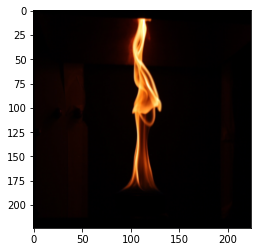

In [14]:
train_features, train_labels = next(iter(train_data_loader))
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
print(f"Label: {label}")

### Loading the pretrained torchvision ResNet-34 model and replacing the final classification output-layer to match the number of burning liquid classes.

In [15]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# find, ResNet::forward, self.fc
num_classes = 3
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [107]:
# model.load_state_dict(torch.load('./model_path/model.pt')['model_state_dict'])

### Training model by freezing all the weights except the final classification output layer

In [19]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [28]:
## Using cross entropy loss funtion and testing with learning rate 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [30]:
batch_size = 64

In [31]:
def train_model(model_to_train):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        model_to_train.train(True)
        total_train_num_steps = len(train_dataset)//batch_size
        total = 0.0
        correct = 0.0
        for num_steps in range(total_train_num_steps):
            # print('Steps number = ', num_steps)
            inputs, labels = next(iter(train_data_loader))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_to_train(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        print(f'Training loss for epoch {epoch + 1}: {running_loss / total_train_num_steps:.3f}')
        print(f'Training accuracy for epoch {epoch + 1}: {correct / total:.3f}')

        train_loss.append(round(running_loss/ total_train_num_steps, 3))
        train_accuracy.append(round(correct/ total, 3))
        running_loss = 0.0
        model_to_train.eval()
        running_vloss = 0.0
        vtotal = 0.0
        vcorrect = 0.0
        total_val_steps = len(validate_dataset)//batch_size
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for num_steps in range(total_val_steps):
                vinputs, vlabels = next(iter(validate_data_loader))
                voutputs = model_to_train(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                _, predicted = torch.max(voutputs.data, 1)
                vtotal += vlabels.size(0)
                vcorrect += (predicted == labels).sum().item()


            print(f'Validation loss : {running_vloss / total_val_steps:.3f}')
            print(f'Validation accuracy : {vcorrect / vtotal:.3f}')
            val_loss.append(round(running_vloss/ total_val_steps, 3))
            val_accuracy.append(round(vcorrect/ vtotal, 3))



#         torch.save({
#                   'epoch': 10,
#                   'model_state_dict': model_to_train.state_dict(),
#                   'optimizer_state_dict': optimizer.state_dict()
#                   }, './model_path/model.pt')
        print('\n')
    return model_to_train, train_loss, val_loss, train_accuracy, val_accuracy

In [42]:
def plot_train_val_graphs(train_values, validation_values, label='Loss'):
    epochs = range(1, len(train_values)+1)

    # Plot and label the training and validation loss values
    plt.plot(epochs, train_values, label='Training '+label)
    plt.plot(epochs, validation_values, label='Validation '+label)

    # Add in a title and axes labels
    plt.title('Training and Validation '+label)
    plt.xlabel('Epochs')
    plt.ylabel(label)

    # Set the tick locations
    plt.xticks(arange(0, len(train_values), 2))

    # Display the plot
    plt.legend(loc='best')
    plt.show()

In [24]:
model, train_loss, val_loss, train_accuracy, val_accuracy = train_model(model)

Training loss for epoch 1: 1.243
Training accuracy for epoch 1: 0.344
Validation loss : 1.076
Validation accuracy : 0.254


Training loss for epoch 2: 1.137
Training accuracy for epoch 2: 0.383
Validation loss : 1.069
Validation accuracy : 0.293


Training loss for epoch 3: 1.116
Training accuracy for epoch 3: 0.377
Validation loss : 1.021
Validation accuracy : 0.363


Training loss for epoch 4: 1.097
Training accuracy for epoch 4: 0.384
Validation loss : 1.030
Validation accuracy : 0.273


Training loss for epoch 5: 1.089
Training accuracy for epoch 5: 0.399
Validation loss : 1.045
Validation accuracy : 0.359


Training loss for epoch 6: 1.070
Training accuracy for epoch 6: 0.444
Validation loss : 1.049
Validation accuracy : 0.270


Training loss for epoch 7: 1.072
Training accuracy for epoch 7: 0.426
Validation loss : 1.002
Validation accuracy : 0.309


Training loss for epoch 8: 1.071
Training accuracy for epoch 8: 0.444
Validation loss : 0.990
Validation accuracy : 0.285


Training

### Plotting loss and accuracy for both training and validation dataset

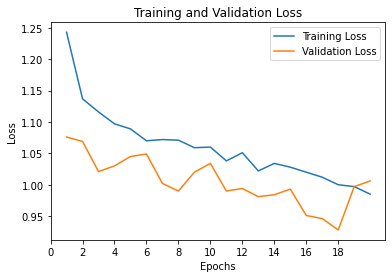

In [29]:
plot_train_val_graphs(train_loss, val_loss, label='Loss')

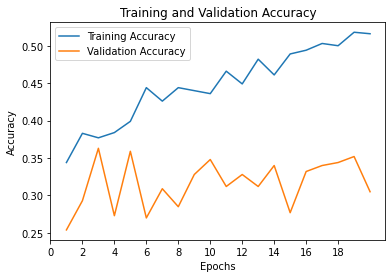

In [30]:
plot_train_val_graphs(train_accuracy, val_accuracy, label='Accuracy')

### Unfreezing the last conv layer from the freezed resnet34 and training the model

In [31]:
for name, param in model.named_parameters():
    if "layer4.2.conv2" in name or "layer4.2.bn2" in name:
        param.requires_grad = True
    print(name,param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

In [32]:
model, train_loss_unfreezed, val_loss_unfreezed, train_accuracy_unfreezed, val_accuracy_unfreezed = train_model(model)

Training loss for epoch 1: 0.995
Training accuracy for epoch 1: 0.513
Validation loss : 0.922
Validation accuracy : 0.281


Training loss for epoch 2: 0.975
Training accuracy for epoch 2: 0.540
Validation loss : 0.932
Validation accuracy : 0.348


Training loss for epoch 3: 0.986
Training accuracy for epoch 3: 0.531
Validation loss : 0.970
Validation accuracy : 0.277


Training loss for epoch 4: 0.971
Training accuracy for epoch 4: 0.536
Validation loss : 0.995
Validation accuracy : 0.332


Training loss for epoch 5: 0.957
Training accuracy for epoch 5: 0.549
Validation loss : 0.927
Validation accuracy : 0.359


Training loss for epoch 6: 0.972
Training accuracy for epoch 6: 0.536
Validation loss : 0.936
Validation accuracy : 0.312


Training loss for epoch 7: 0.947
Training accuracy for epoch 7: 0.559
Validation loss : 0.911
Validation accuracy : 0.336


Training loss for epoch 8: 0.943
Training accuracy for epoch 8: 0.565
Validation loss : 0.926
Validation accuracy : 0.328


Training

### Plotting the loss and accuracy after unfreezing the conv layer

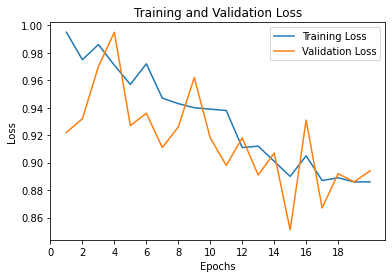

In [33]:
plot_train_val_graphs(train_loss_unfreezed, val_loss_unfreezed, label='Loss')

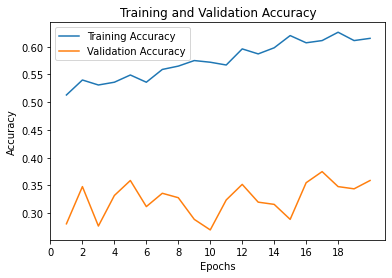

In [34]:
plot_train_val_graphs(train_accuracy_unfreezed, val_accuracy_unfreezed, label='Accuracy')

### Reducing the learning rate to 1e-5 

In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)

In [36]:
model, train_loss_new_lr, val_loss_new_lr, train_accuracy_new_lr, val_accuracy_new_lr = train_model(model)

Training loss for epoch 1: 0.885
Training accuracy for epoch 1: 0.598
Validation loss : 0.858
Validation accuracy : 0.309


Training loss for epoch 2: 0.877
Training accuracy for epoch 2: 0.624
Validation loss : 0.871
Validation accuracy : 0.328


Training loss for epoch 3: 0.882
Training accuracy for epoch 3: 0.620
Validation loss : 0.835
Validation accuracy : 0.258


Training loss for epoch 4: 0.875
Training accuracy for epoch 4: 0.623
Validation loss : 0.910
Validation accuracy : 0.316


Training loss for epoch 5: 0.882
Training accuracy for epoch 5: 0.624
Validation loss : 0.896
Validation accuracy : 0.340


Training loss for epoch 6: 0.881
Training accuracy for epoch 6: 0.612
Validation loss : 0.846
Validation accuracy : 0.254


Training loss for epoch 7: 0.867
Training accuracy for epoch 7: 0.634
Validation loss : 0.874
Validation accuracy : 0.371


Training loss for epoch 8: 0.869
Training accuracy for epoch 8: 0.630
Validation loss : 0.870
Validation accuracy : 0.328


Training

### Plotting loss and accuracy with modified learning rate value

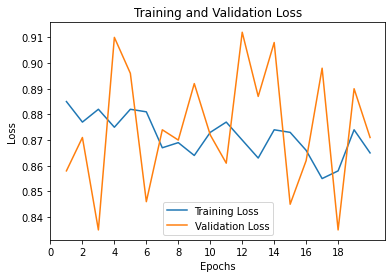

In [37]:
plot_train_val_graphs(train_loss_new_lr, val_loss_new_lr, label='Loss')

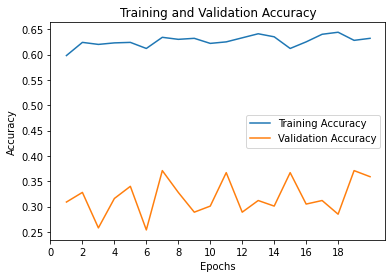

In [38]:
plot_train_val_graphs(train_accuracy_new_lr, val_accuracy_new_lr, label='Accuracy')

## Layer Visualization

In [101]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [93]:
def visualize_hook(module, input, output):
    plt.figure(figsize=(20, 20))
    nval = math.ceil(math.sqrt(output.size(1)))
    row, col = nval, nval
    for i in range(output.size(1)):
#         print(output.size(1), i)
        plt.subplot(row, col, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()


### Visualizing the feature maps of the selected conv layers from the model architecture

In [103]:
conv_layers_outputs = [model.layer1[0].conv1, model.layer1[1].conv2, model.layer1[2].conv2, model.layer2[3].conv2, model.layer4[2].conv2]

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 



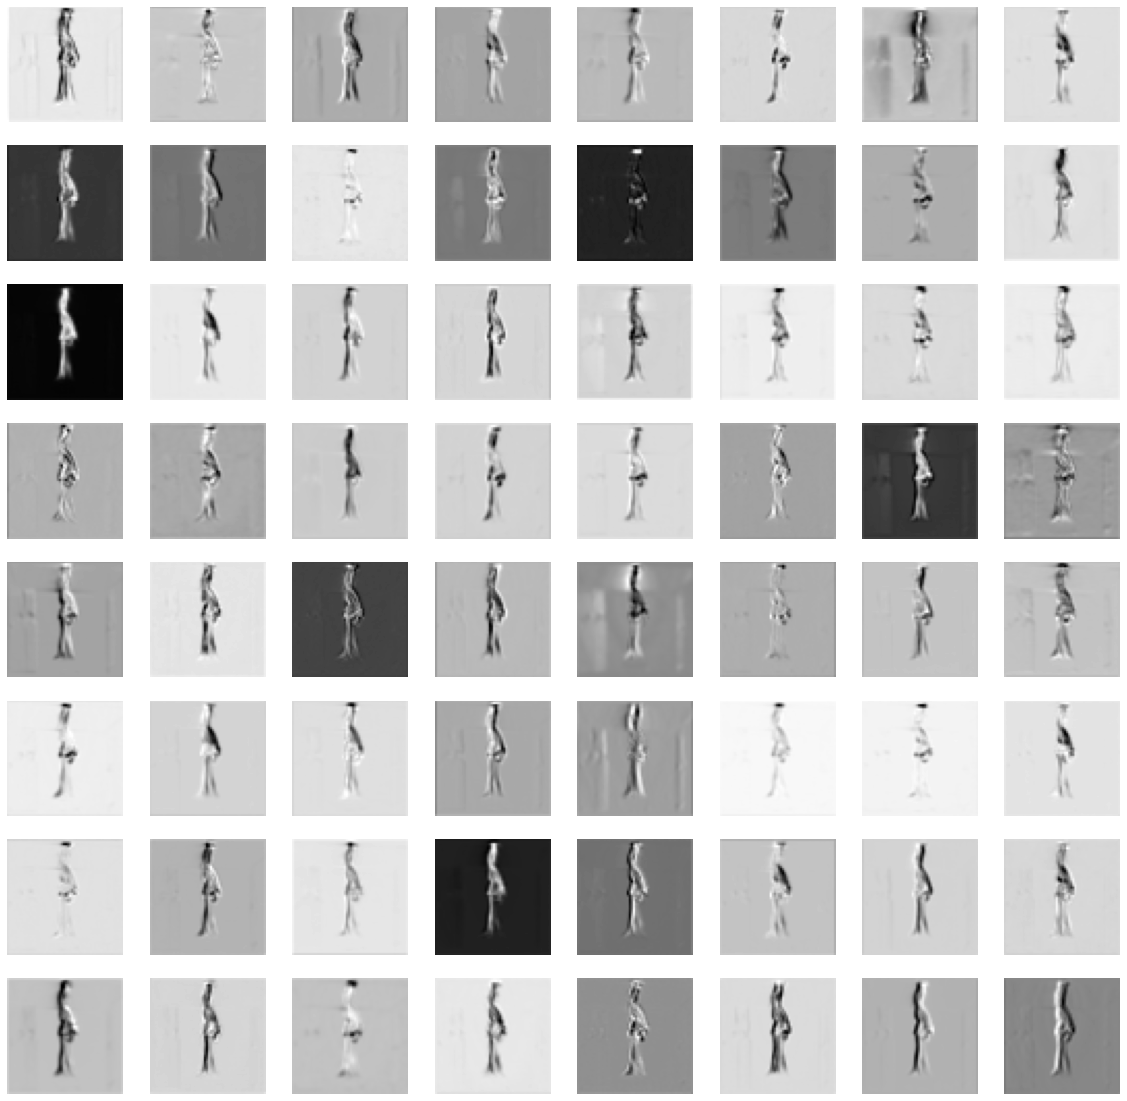

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 



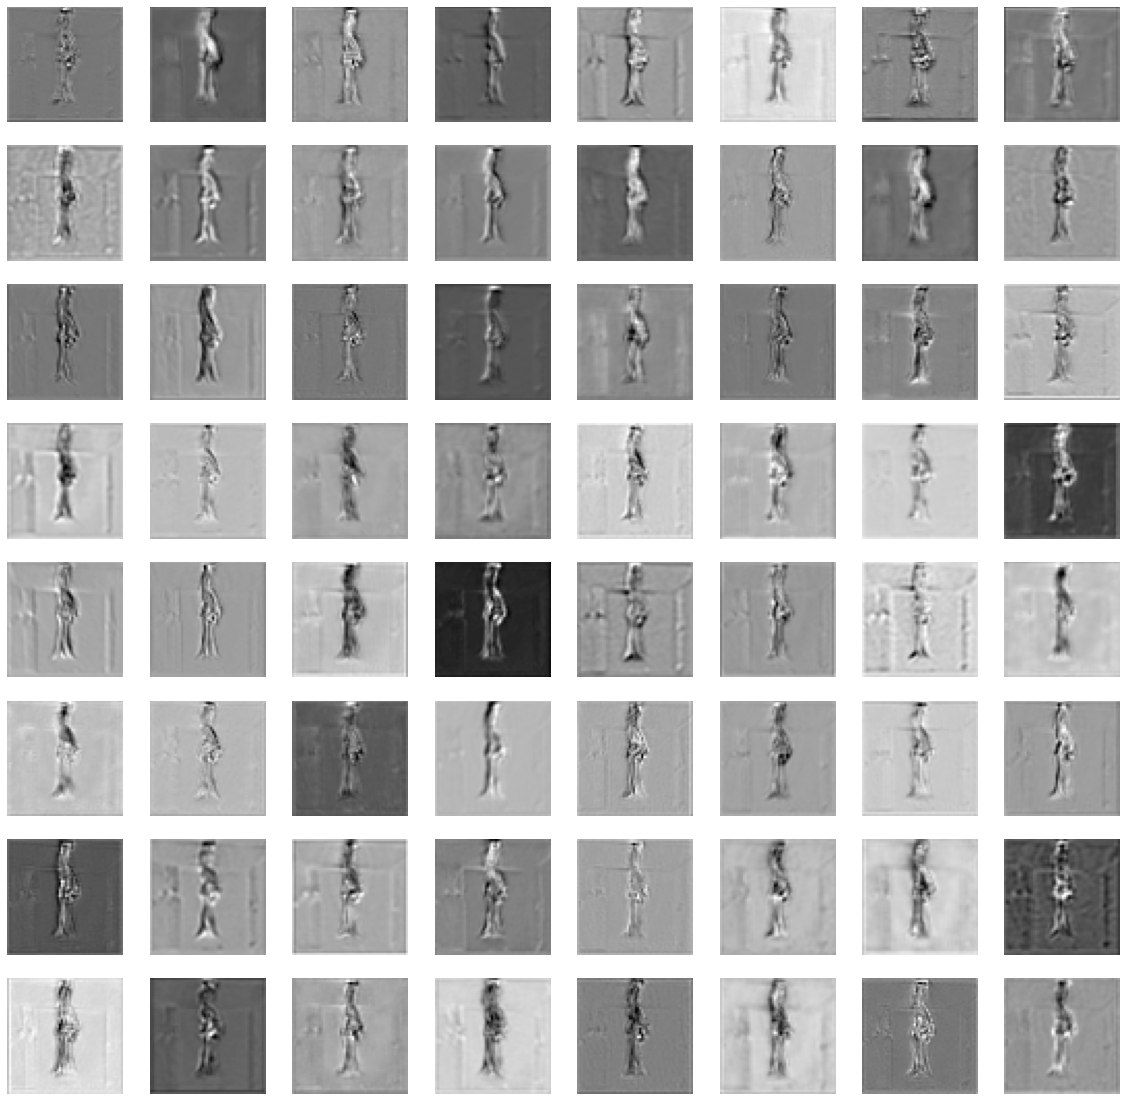

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 



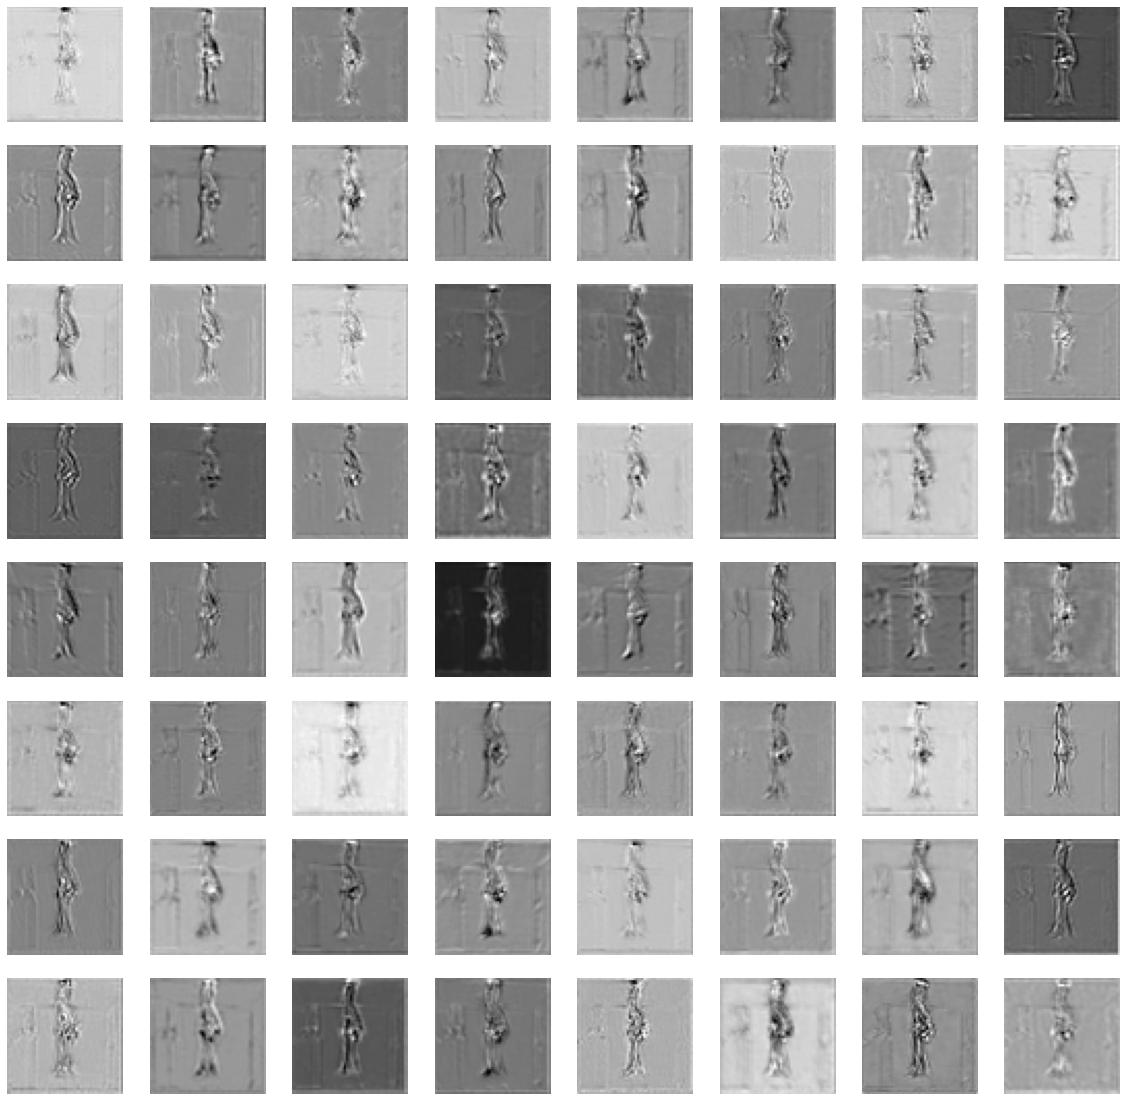

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 



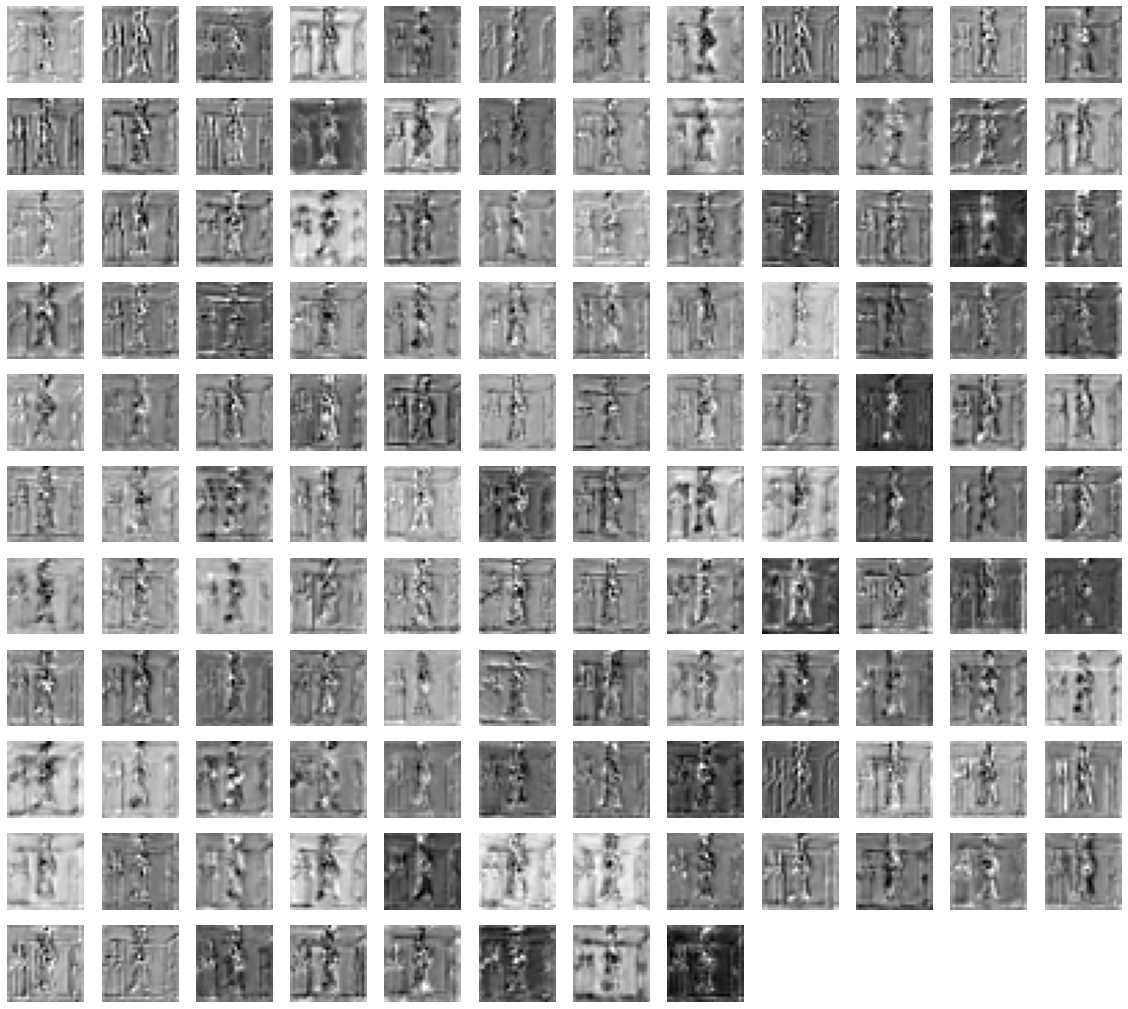

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) 



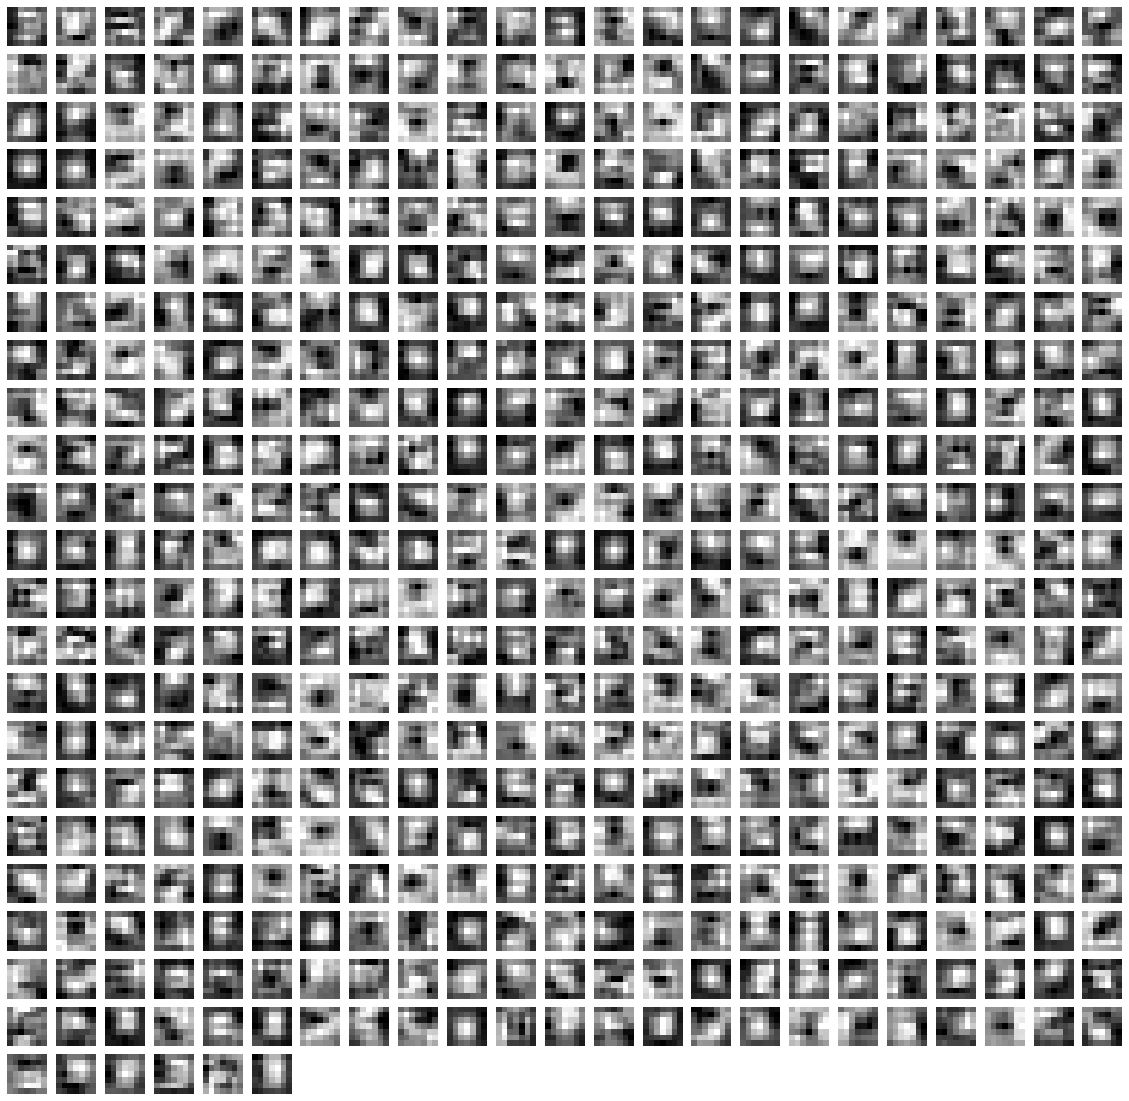

In [104]:
for conv_layer_name in conv_layers_outputs:
    layer_to_visualize = conv_layer_name
    print(conv_layer_name, '\n')
    hook = layer_to_visualize.register_forward_hook(visualize_hook)
    # Run a single image through the model
    image = train_features[0].unsqueeze(0) # Replace this with a real image from the dataset
    _ = model(image)
    hook.remove()

### Visualizing the feature maps from the selected activation function layers 

In [78]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.ReLU):
        print(name, layer)


relu ReLU(inplace=True)
layer1.0.relu ReLU(inplace=True)
layer1.1.relu ReLU(inplace=True)
layer1.2.relu ReLU(inplace=True)
layer2.0.relu ReLU(inplace=True)
layer2.1.relu ReLU(inplace=True)
layer2.2.relu ReLU(inplace=True)
layer2.3.relu ReLU(inplace=True)
layer3.0.relu ReLU(inplace=True)
layer3.1.relu ReLU(inplace=True)
layer3.2.relu ReLU(inplace=True)
layer3.3.relu ReLU(inplace=True)
layer3.4.relu ReLU(inplace=True)
layer3.5.relu ReLU(inplace=True)
layer4.0.relu ReLU(inplace=True)
layer4.1.relu ReLU(inplace=True)
layer4.2.relu ReLU(inplace=True)


In [105]:
activation_layers = [model.layer1[0].relu, model.layer1[1].relu, model.layer1[2].relu, model.layer2[0].relu, model.layer4[2].relu]

ReLU(inplace=True) 



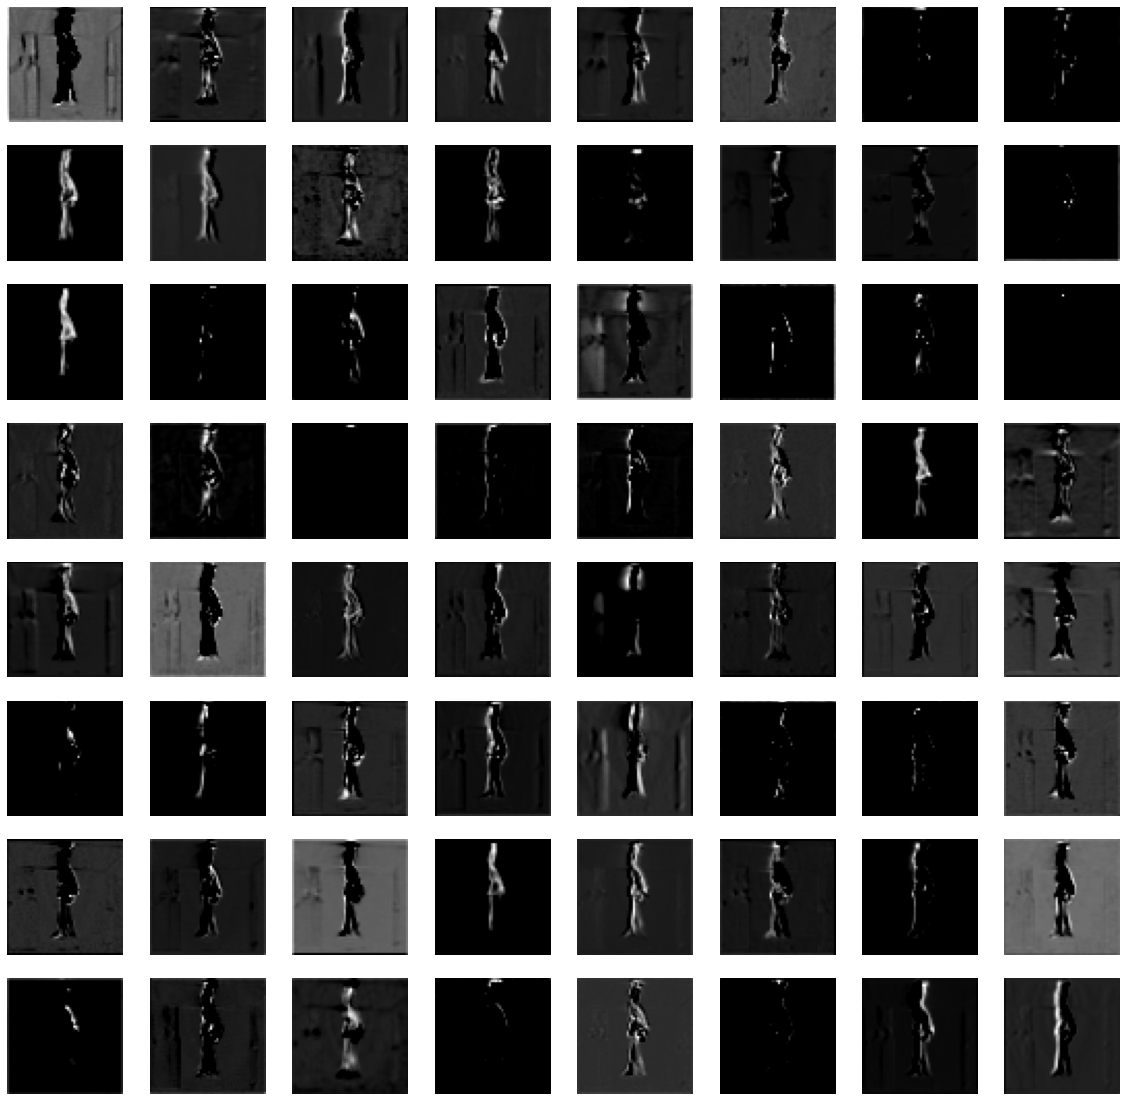

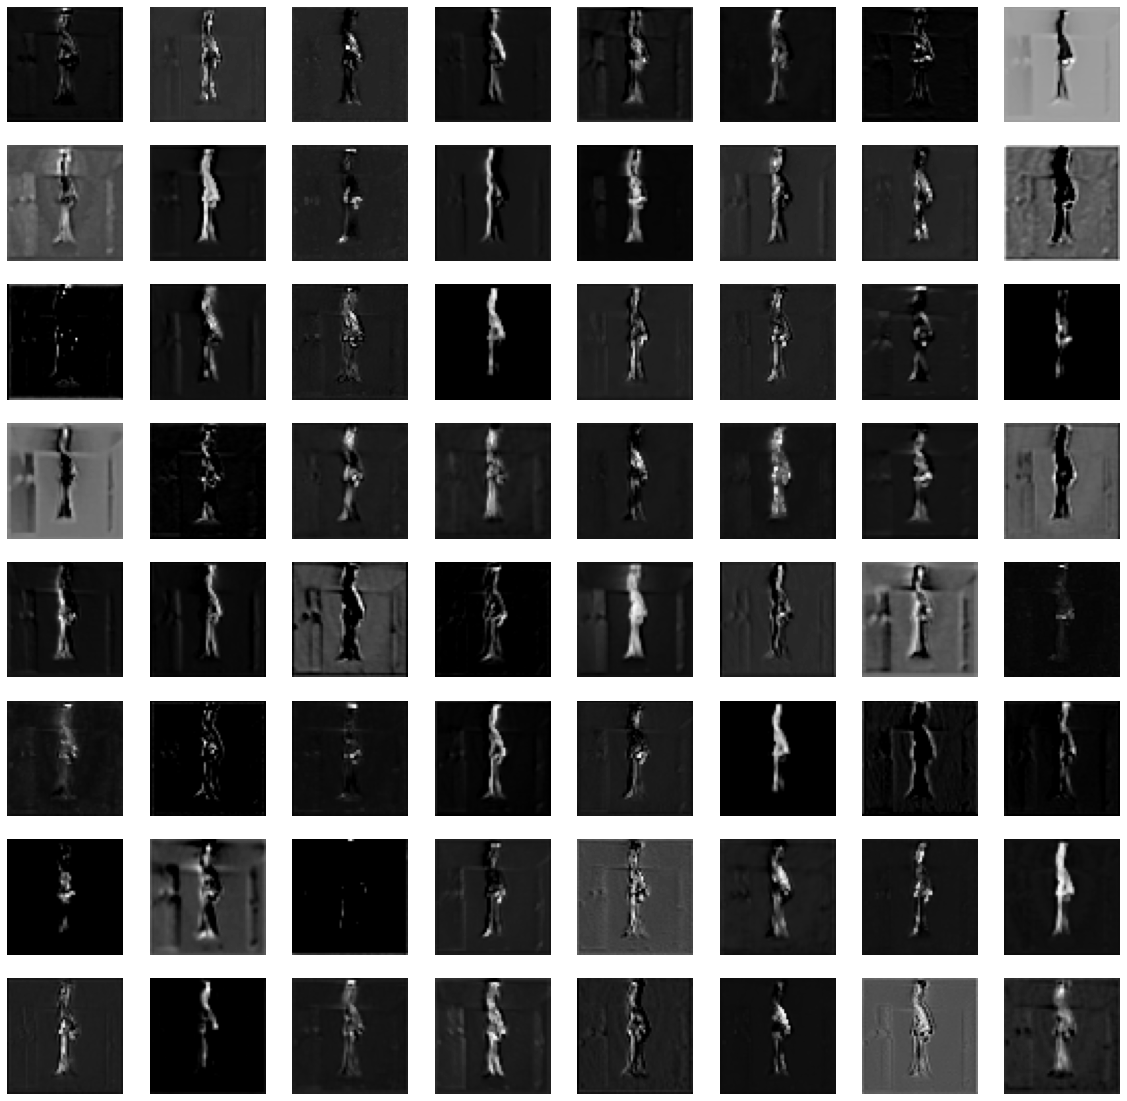

ReLU(inplace=True) 



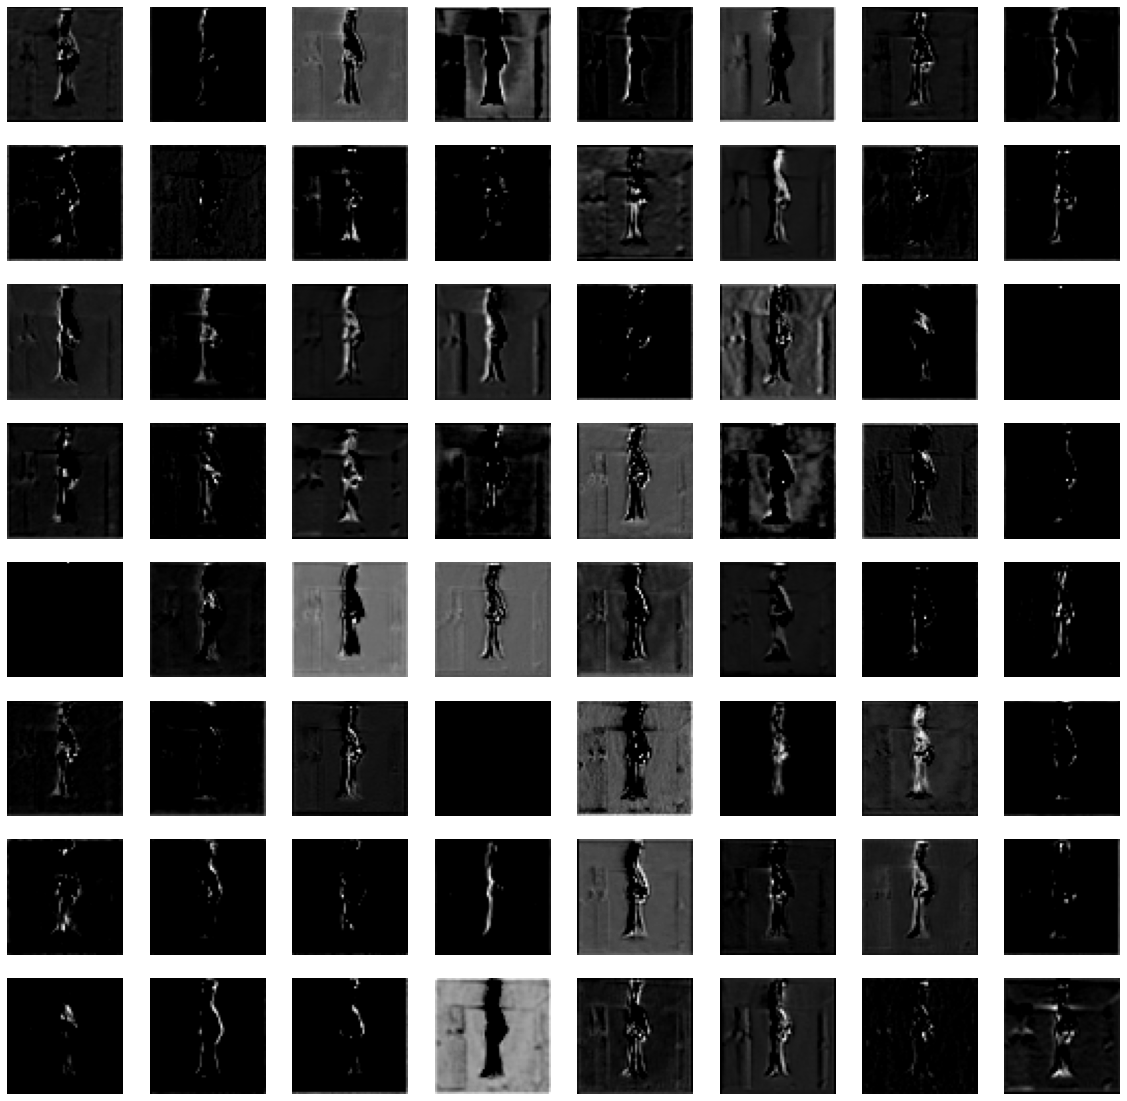

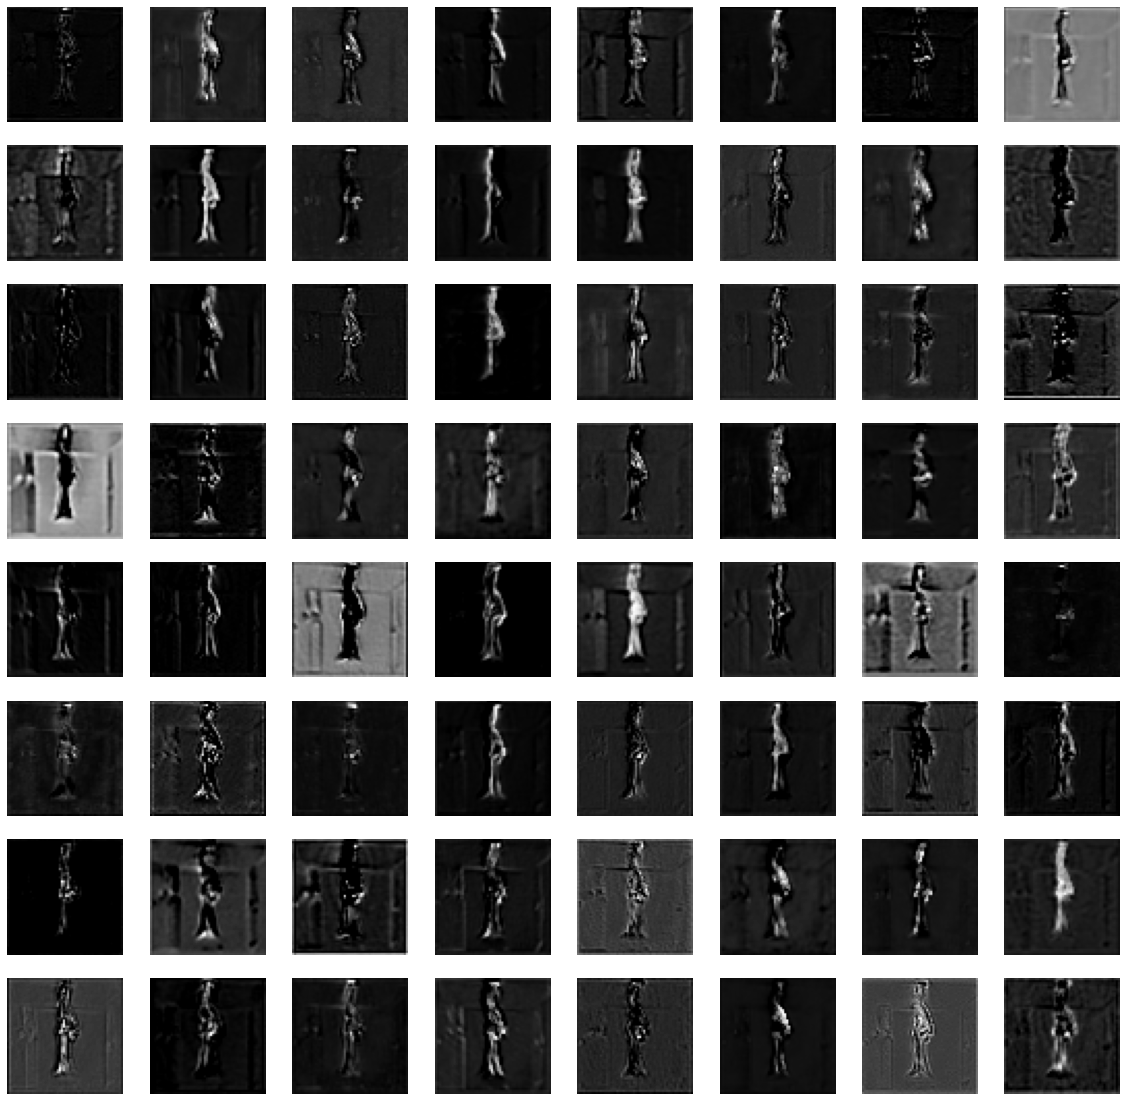

ReLU(inplace=True) 



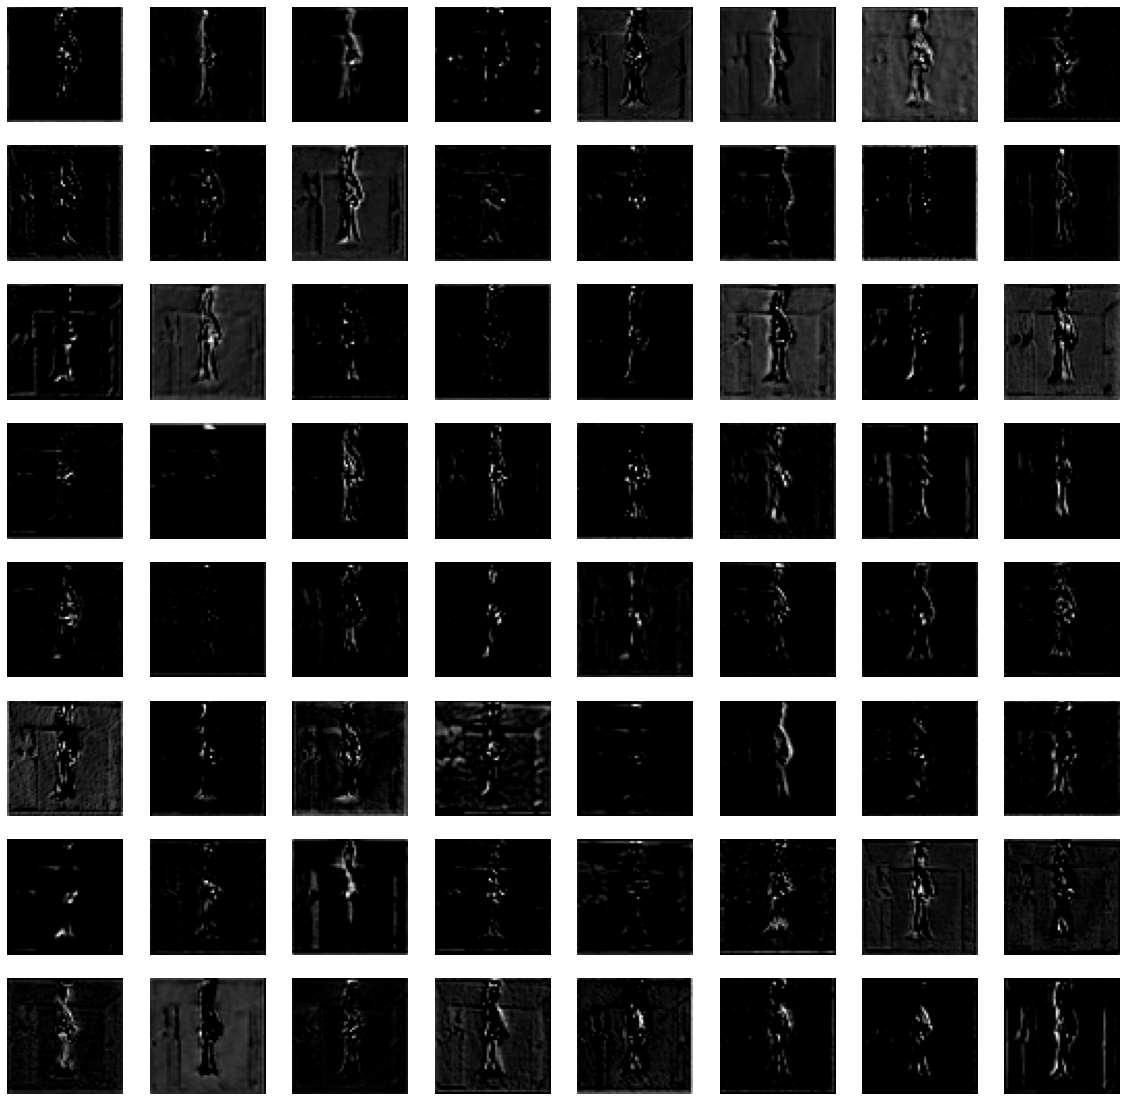

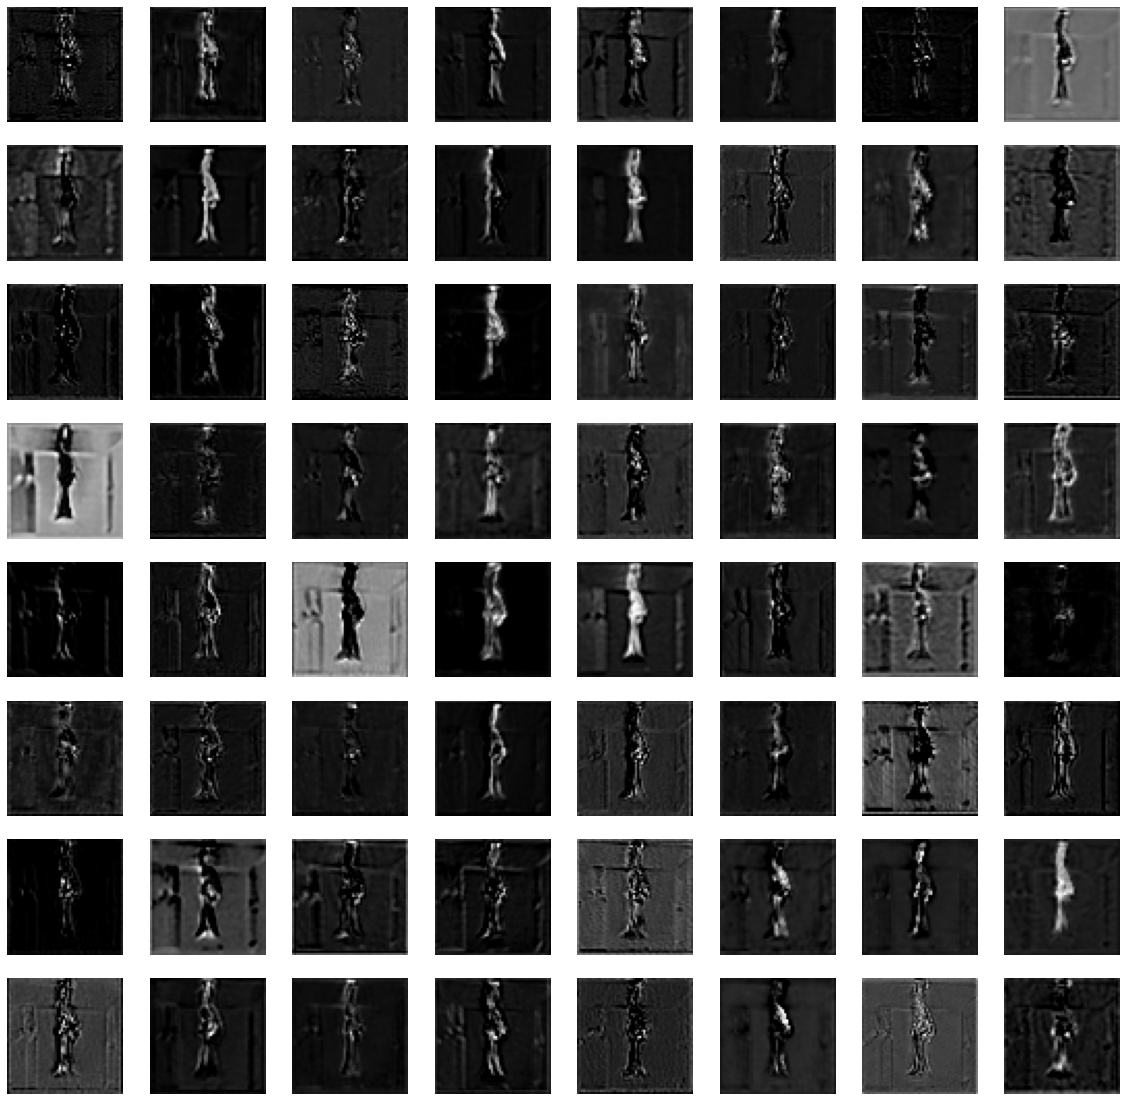

ReLU(inplace=True) 



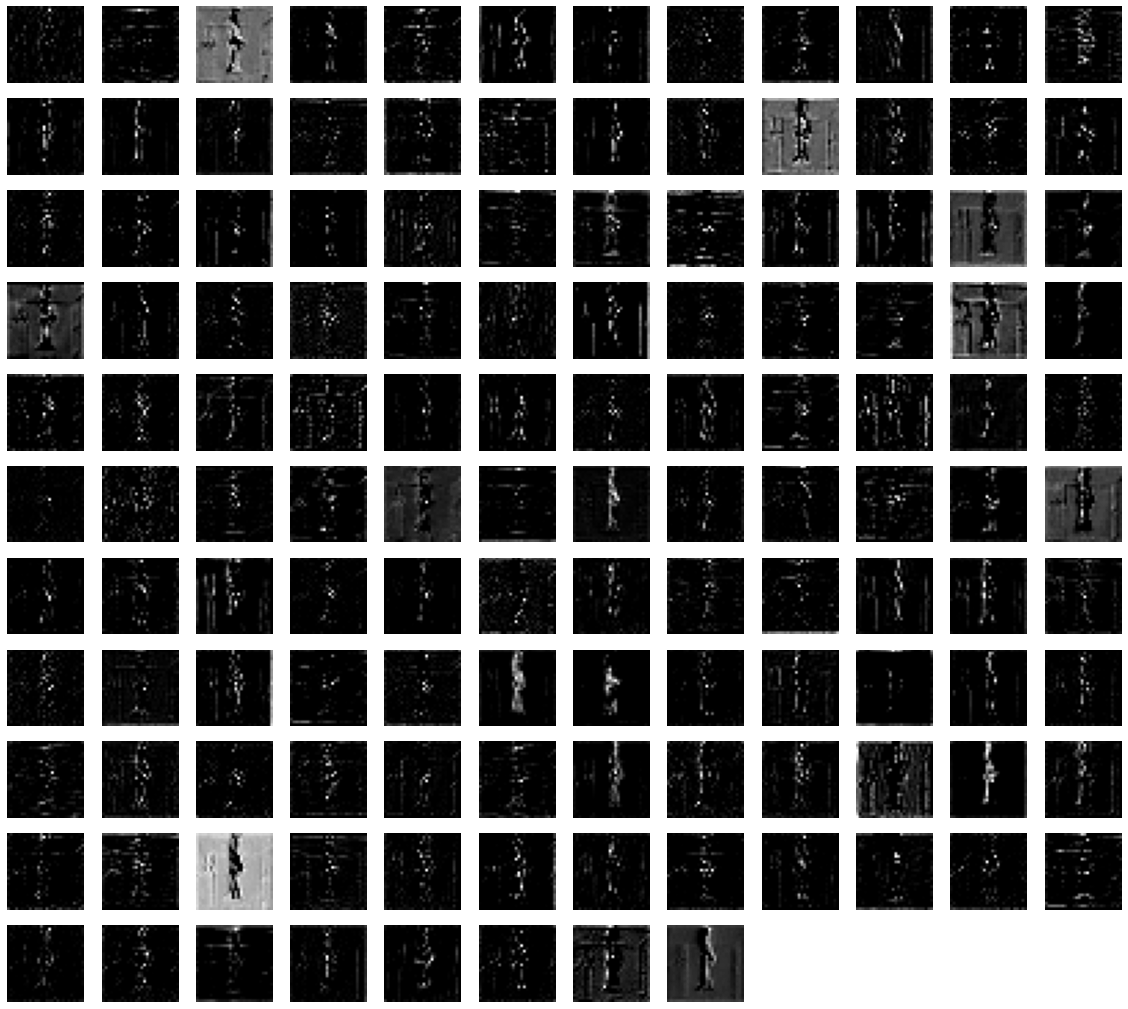

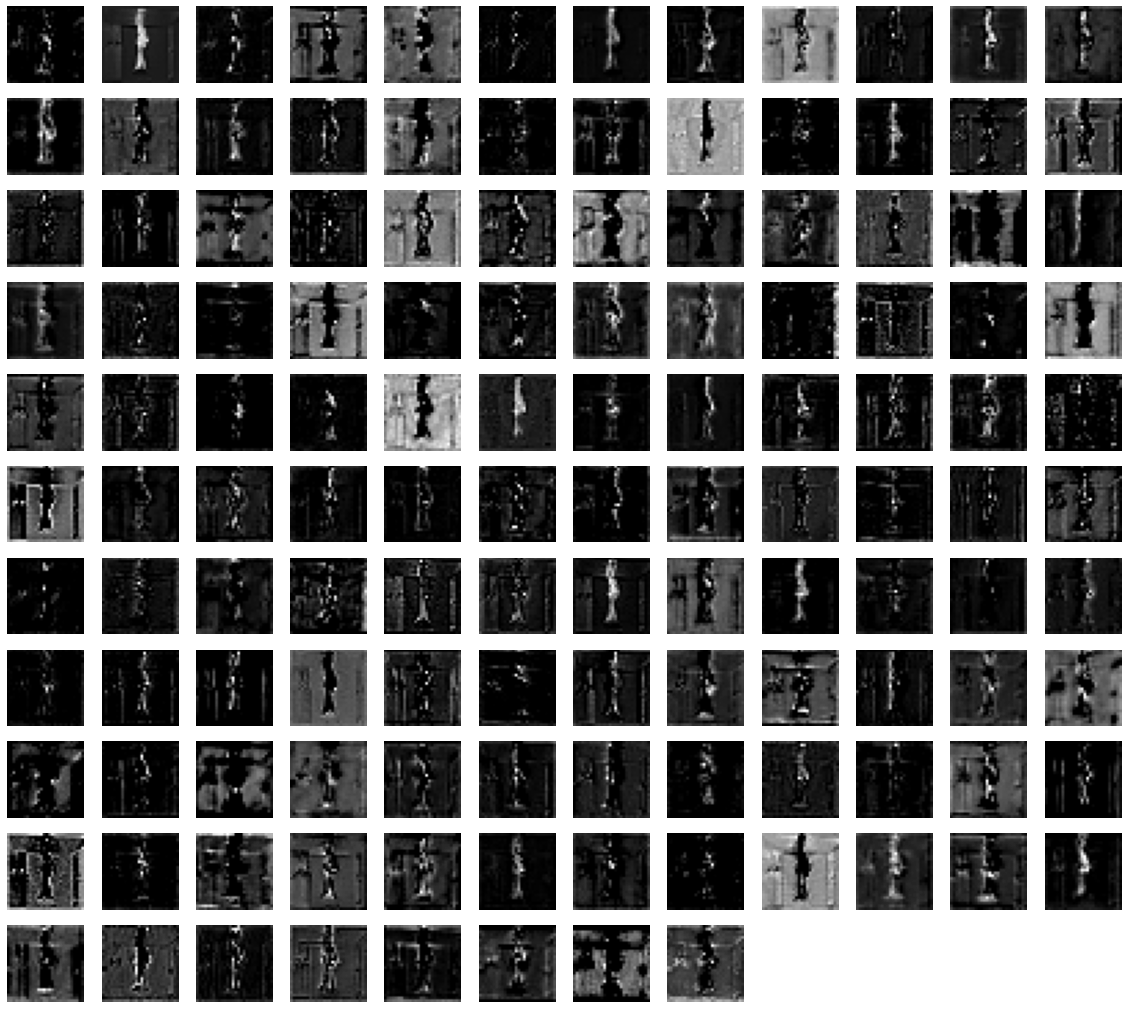

ReLU(inplace=True) 



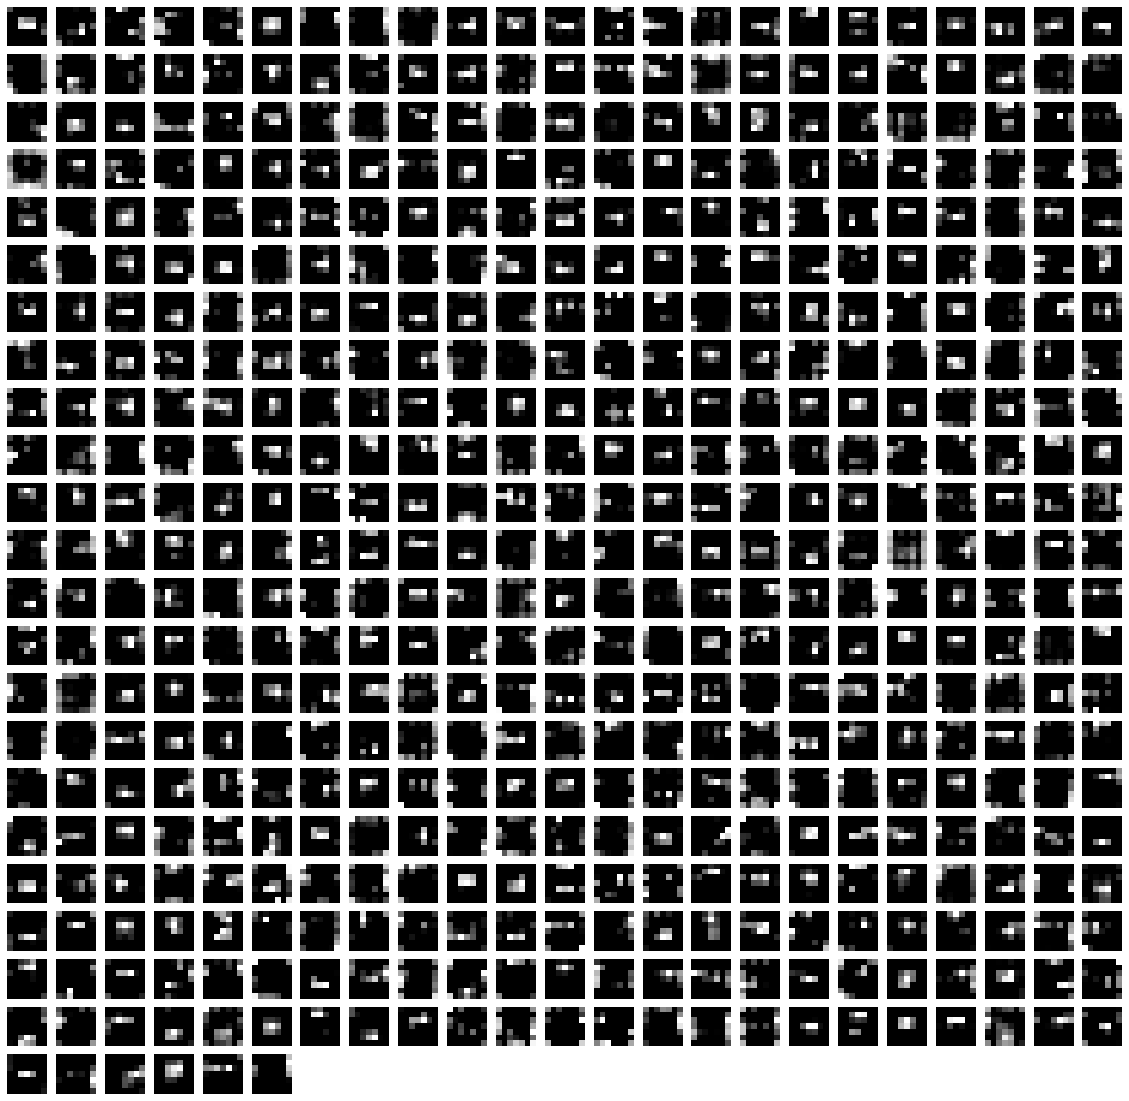

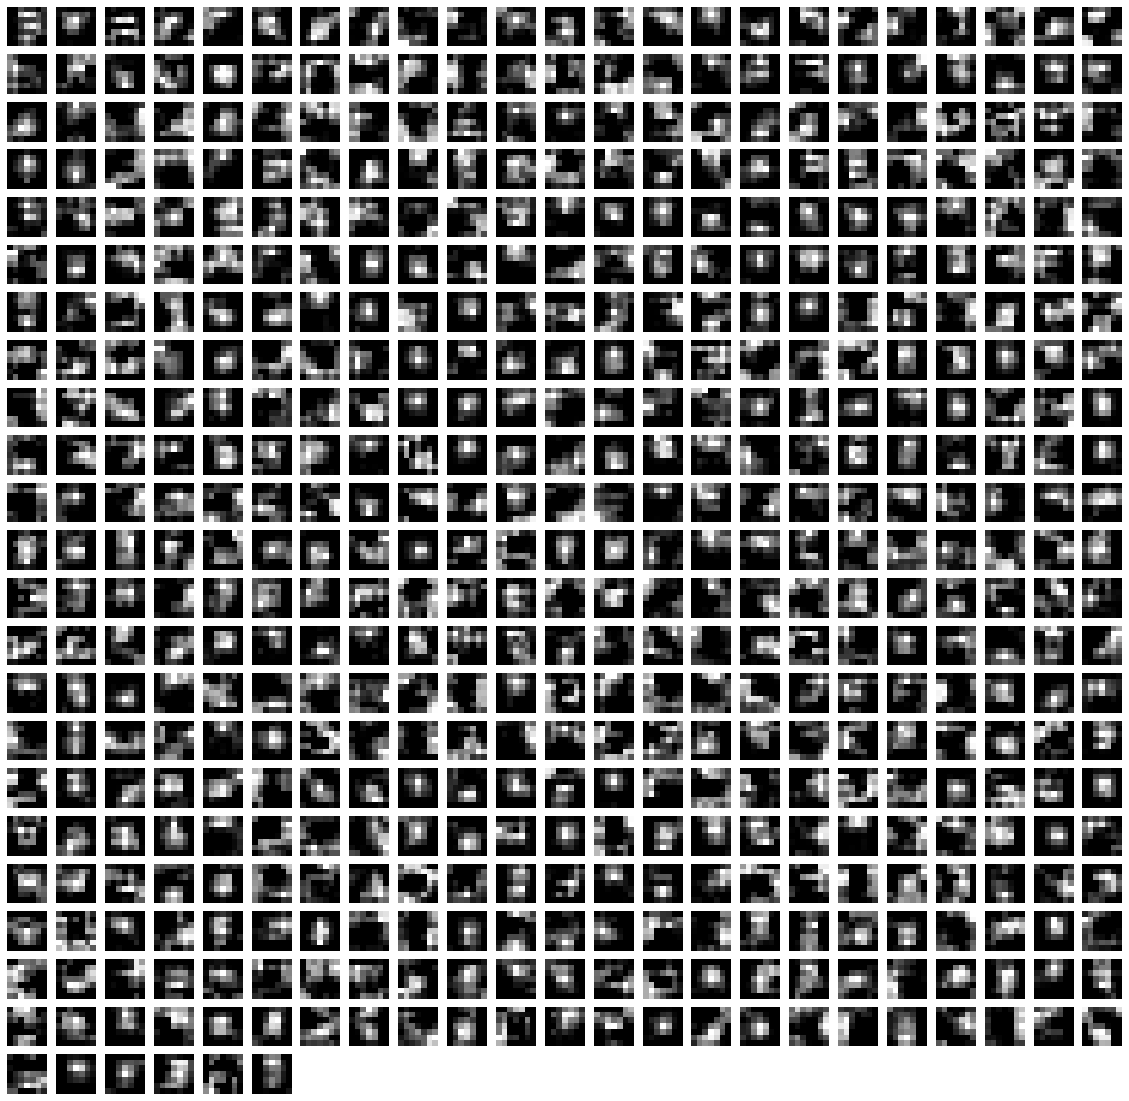

In [106]:
for relu_layer_name in activation_layers:
    layer_to_visualize = relu_layer_name
    print(relu_layer_name, '\n')
    hook = layer_to_visualize.register_forward_hook(visualize_hook)
    # Run a single image through the model
    image = train_features[0].unsqueeze(0) # Replace this with a real image from the dataset
    _ = model(image)
    hook.remove()

## Analysis

### Report the accuracy of the fine-tuned model on the testing set. Compare the accuracy to the baseline vanilla pretrained ResNet-34 model.

In [17]:
vanilla_model = resnet34(pretrained=True)
vanilla_model.fc = nn.Linear(vanilla_model.fc.in_features, num_classes)

In [33]:
def calculate_accuracy_on_test_data(test_model, data):
    num_correct = 0
    num_samples = 0
    y_true = []
    y_pred = []
    for i in range(len(data)):
        inputs, labels = data[i]
        y_true.append(labels)
        pred = test_model(inputs.unsqueeze(0))
        _, predictions = torch.max(pred, 1)
        y_pred.append(predictions)
        num_correct += (predictions == labels).sum().item()
        num_samples += predictions.size(0)
    accuracy = (float(num_correct)/float(num_samples)*100)
    return accuracy, y_true, y_pred

In [76]:
vanilla_model_accuracy_on_test_data, true_labels, vanilla_pred_results = calculate_accuracy_on_test_data(vanilla_model, test_dataset)
model_accuracy_on_test_data, true_labels, model_pred_results = calculate_accuracy_on_test_data(model, test_dataset)

print("Vanilla model resnet accuracy on test unseen data is ", vanilla_model_accuracy_on_test_data)
print('Trained model resnet accuracy on test unseen data is ', model_accuracy_on_test_data)


Vanilla model resnet accuracy on test unseen data is  32.0
Trained model resnet accuracy on test unseen data is  38.333333333333336


### Confusion matrix to show inter-class error rates

<Axes: >

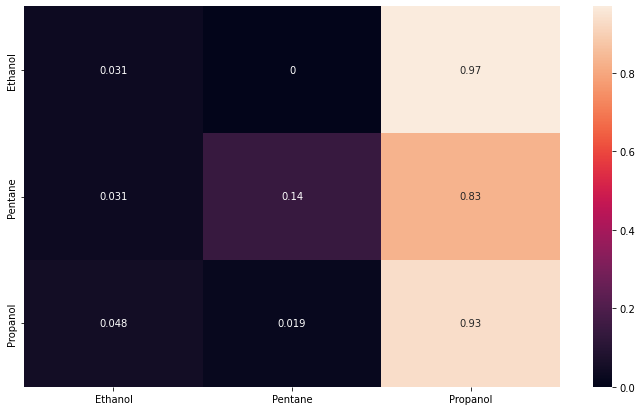

In [79]:
cf_matrix = confusion_matrix(true_labels, model_pred_results)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

### Calculating the precision and recall for each class and plotting the Precision-Recall curves

In [77]:
model_pred_results = [i.data.numpy()[0] for i in model_pred_results]
pred_binarize = label_binarize(model_pred_results, classes=[0, 1, 2])

In [78]:
true_labels_binarize = label_binarize(true_labels, classes=[0, 1, 2])

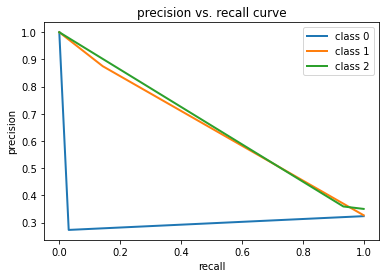

In [81]:
n_classes = 3
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarize[:, i],
                                                        pred_binarize[:, i])
    average_precision[i] = average_precision_score(true_labels_binarize[:, i], pred_binarize[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


In [82]:
precision["micro"], recall["micro"], _ = precision_recall_curve(
    true_labels_binarize.ravel(), pred_binarize.ravel()
)
average_precision["micro"] = average_precision_score(true_labels_binarize, pred_binarize, average="micro")


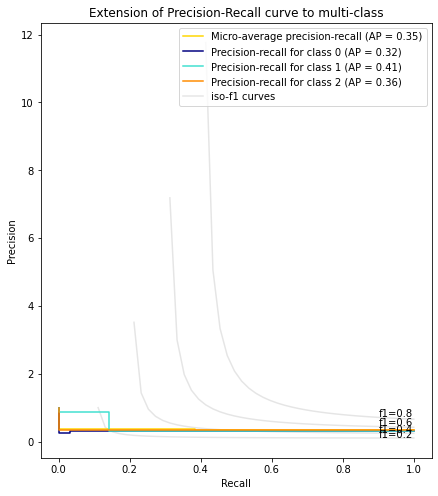

In [84]:

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()